# Stromzeiten Carbon Emission Forecast


In [177]:
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

In [300]:
import importlib
import src.entsoe_collector
importlib.reload(src.entsoe_collector)

<module 'src.entsoe_collector' from '/Users/hubertstinia/Stromzeiten_datacollector/src/entsoe_collector.py'>

In [301]:
from src.weatherapi_collector import CurrentWeather, WeatherForecast, HistoricalWeather
import importlib
from src.entsoe_collector import Forecast, Generation, Load, Prices
import pandas as pd
from dotenv import load_dotenv
from utils.logger import CustomFormatter
import datetime
import logging
load_dotenv()

# you can reload "folder_name.filename" if you do not use molude name alias


# Set up logging
logger = logging.getLogger("Testing")
logger.setLevel(logging.INFO)
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(CustomFormatter())
logger.addHandler(ch)
logger.propagate = False


WEEK_AGO: datetime = datetime.date.today() - datetime.timedelta(days=7)
TODAY: datetime = datetime.date.today()
TOMORROW: datetime = datetime.date.today()+datetime.timedelta(days=1)
DAYS_FORECAST = 3

country_code = "BE"
tz = "Europe/Brussels"
city = "Brussels"
country = "Belgium"


start_date = pd.Timestamp(WEEK_AGO, tz=tz)
end_date = pd.Timestamp(TOMORROW, tz=tz)

generation, emissions = Generation(
    start_date, end_date, country_code).fetch_process_and_calculate_emissions()

weather_forecast = WeatherForecast(city, tz, DAYS_FORECAST).fetch()

In [311]:
WEEK_AGO: datetime = datetime.date.today() - datetime.timedelta(days=7)
TODAY: datetime = datetime.date.today()
TOMORROW: datetime = datetime.date.today()+datetime.timedelta(days=1)
DAYS_FORECAST = 3

country_code = "DE"
country = "Germany"
tz = "Europe/Brussels"
city = "Berlin"


def fetch_forecast_data(country_code, country, city, tz):
    start_date = pd.Timestamp(WEEK_AGO, tz=tz)
    end_date = pd.Timestamp(TOMORROW, tz=tz)
    generation, emissions = Generation(
        start_date, end_date, country_code).fetch_process_and_calculate_emissions()
    weather_forecast = WeatherForecast(city, tz, DAYS_FORECAST).fetch()
    week_of_data = pd.date_range(
        WEEK_AGO, TOMORROW-datetime.timedelta(days=1), freq='d')
    historical_weather_list = []
    for day in week_of_data:
        historical = HistoricalWeather(city, tz, DAYS_FORECAST).fetch(day)
        historical_weather_list.append(historical)
    historical_weather = pd. concat(historical_weather_list)
    emissions = emissions.asfreq('H')
    emissions = emissions.fillna(0.0)
    emissions.index= emissions.index.tz_convert(tz)
    historical_data = emissions.join(historical_weather)
    weather_forecast = weather_forecast[~weather_forecast.index.isin(
        historical_data.index)]
    return emissions, generation, historical_data, weather_forecast

In [312]:
from dataclasses import dataclass


@dataclass
class Next3DaysForecast(object):
    
    historical_data: pd.DataFrame
    weather_forecast: pd.DataFrame

    def create_features(self, df):
        """
        Create time series features based on time series index.
        """
        df = df.copy()
        df['hour'] = df.index.hour
        df['dayofweek'] = df.index.dayofweek
        return df

    def add_lags(self, df):
        target_map = df['Carbon_Intensity_CEI'].to_dict()
        df['lag1'] = (df.index - pd.Timedelta('72 hour')).map(target_map)
        return df

    def train_and_predict(self):
        historical_data_featrues = self.create_features(self.historical_data)
        weather_forecast_featrues = self.create_features(self.weather_forecast)

        FEATURES = ['temp_c', 'wind_kph', 'wind_degree', 'pressure_mb', 'precip_mm',
                    'humidity', 'cloud', 'feelslike_c', 'windchill_c', 'vis_km', 'hour',
                    'dayofweek']
        TARGET = 'Carbon_Intensity_CEI'

        X_train = historical_data_featrues[FEATURES]
        y_train = historical_data_featrues[TARGET]

        X_test = weather_forecast_featrues[FEATURES]

        reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                               n_estimators=5000,
                               early_stopping_rounds=50,
                               objective='reg:linear',
                               max_depth=5,
                               learning_rate=0.02)
        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train)],
                verbose=100)
        weather_forecast_featrues['Cei_prediction'] = reg.predict(X_test)

        """
        merge=pd.merge(historical_data,weather_forecast['Cei_prediction'], how='outer', left_index=True, right_index=True)

        ax = historical_data[['Carbon_Intensity_CEI']].plot(figsize=(15, 5))
        merge['Cei_prediction'].plot(ax=ax, style='-')
        plt.legend(['Real Data', 'Predictions'])
        ax.set_title('Raw Dat and Prediction')
        plt.show()


        fi = pd.DataFrame(data=reg.feature_importances_,
                    index=reg.feature_names_in_,
                    columns=['importance'])
        fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
        plt.show()
        """
        return weather_forecast_featrues, historical_data_featrues

In [319]:
country_code = "FR"
country = "France"
tz = "Europe/Brussels"
city = "Angers"

emissions, generation, historical_data, weather_forecast = fetch_forecast_data(
    country_code, country, city, tz)
historical_data.columns
forecast, historical = Next3DaysForecast(historical_data,weather_forecast).train_and_predict()

[18:30:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:44.99523
[100]	validation_0-rmse:9.21773
[200]	validation_0-rmse:3.78113
[300]	validation_0-rmse:2.51294
[400]	validation_0-rmse:1.78153
[500]	validation_0-rmse:1.35671
[600]	validation_0-rmse:0.90495
[700]	validation_0-rmse:0.66102
[800]	validation_0-rmse:0.43848
[900]	validation_0-rmse:0.31524
[1000]	validation_0-rmse:0.23917
[1100]	validation_0-rmse:0.19006
[1200]	validation_0-rmse:0.15216
[1300]	validation_0-rmse:0.12192
[1400]	validation_0-rmse:0.09237
[1500]	validation_0-rmse:0.07471
[1600]	validation_0-rmse:0.06006
[1700]	validation_0-rmse:0.04678
[1800]	validation_0-rmse:0.03846
[1900]	validation_0-rmse:0.03032
[2000]	validation_0-rmse:0.02368
[2100]	validation_0-rmse:0.01870
[2200]	validation_0-rmse:0.01429
[2300]	validation_0-rmse:0.01164
[2400

In [328]:
for i, j in forecast['Cei_prediction'].items():
    print(i, j)

2023-06-18 17:00:00+02:00 51.82320785522461

2023-06-18 18:00:00+02:00 27.779664993286133

2023-06-18 19:00:00+02:00 21.45823860168457

2023-06-18 20:00:00+02:00 56.382110595703125

2023-06-18 21:00:00+02:00 62.06662368774414

2023-06-18 22:00:00+02:00 55.81325912475586

2023-06-18 23:00:00+02:00 54.030235290527344

2023-06-19 00:00:00+02:00 42.05200958251953

2023-06-19 01:00:00+02:00 38.128482818603516

2023-06-19 02:00:00+02:00 46.22319030761719

2023-06-19 03:00:00+02:00 36.53884506225586

2023-06-19 04:00:00+02:00 39.30723190307617

2023-06-19 05:00:00+02:00 39.183135986328125

2023-06-19 06:00:00+02:00 35.96052932739258

2023-06-19 07:00:00+02:00 48.872161865234375

2023-06-19 08:00:00+02:00 50.61598587036133

2023-06-19 09:00:00+02:00 43.36302185058594

2023-06-19 10:00:00+02:00 44.56396484375

2023-06-19 11:00:00+02:00 41.65243148803711

2023-06-19 12:00:00+02:00 43.61437225341797

2023-06-19 13:00:00+02:00 47.85312271118164

2023-06-19 14:00:00+02:00 54.57115173339844

2023-06

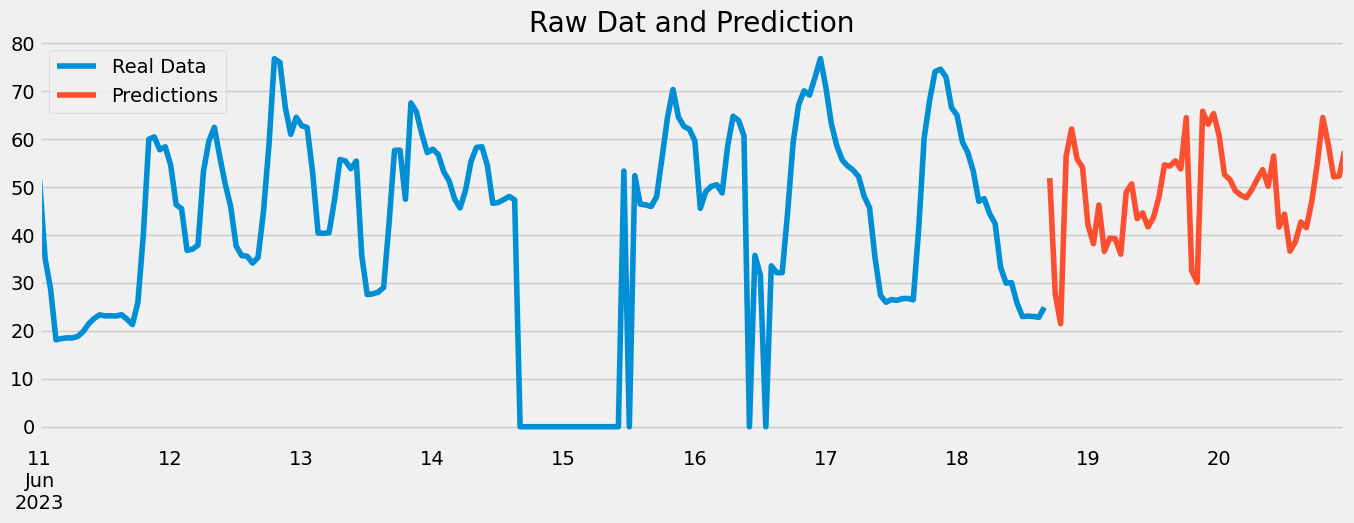

In [320]:
merge=pd.merge(historical,forecast['Cei_prediction'], how='outer', left_index=True, right_index=True)

ax = historical[['Carbon_Intensity_CEI']].plot(figsize=(15, 5))
merge['Cei_prediction'].plot(ax=ax, style='-')
plt.legend(['Real Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

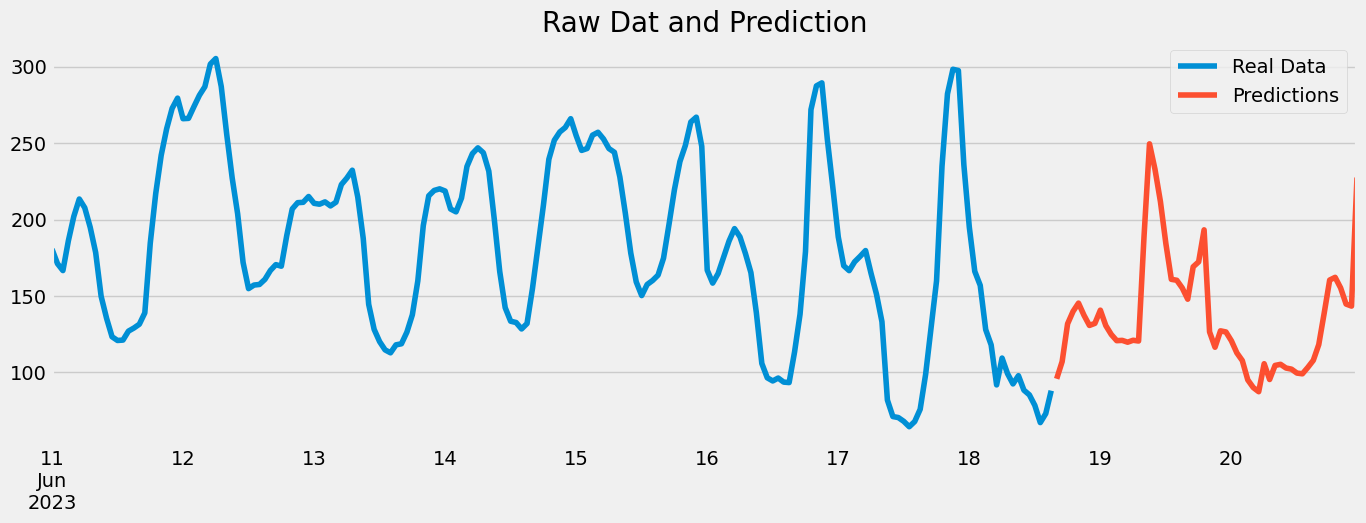

In [245]:
merge=pd.merge(historical,forecast['Cei_prediction'], how='outer', left_index=True, right_index=True)

ax = historical[['Carbon_Intensity_CEI']].plot(figsize=(15, 5))
merge['Cei_prediction'].plot(ax=ax, style='-')
plt.legend(['Real Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()


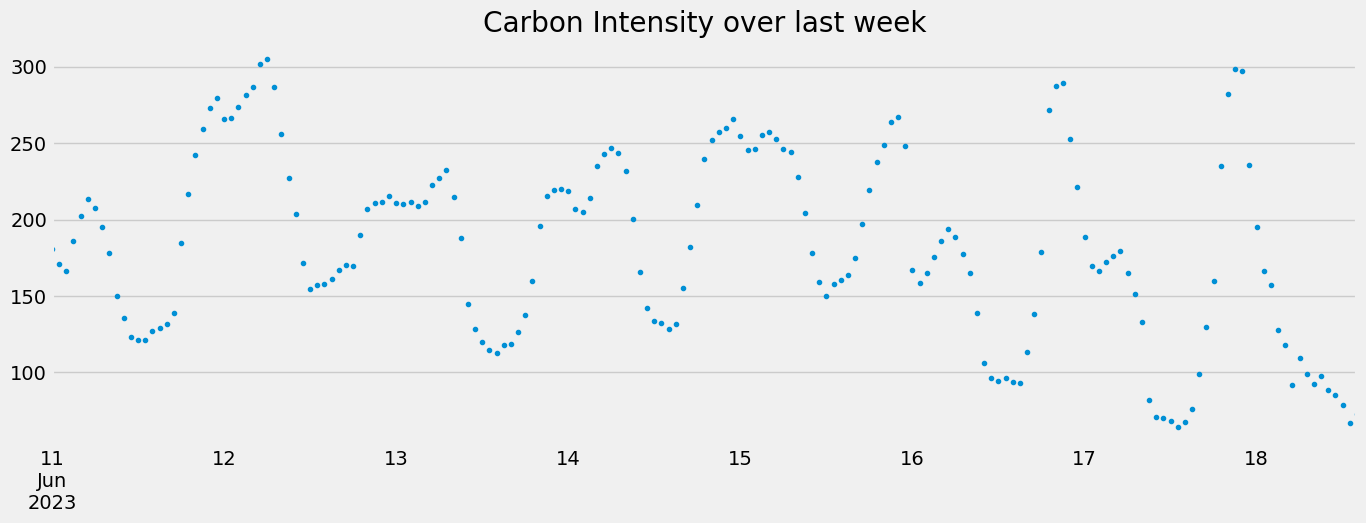

In [180]:
historical_data['Carbon_Intensity_CEI'].plot(style='.',
                                             figsize=(15, 5),
                                             color=color_pal[0],
                                             title='Carbon Intensity over last week')
plt.show()

## Split data


In [181]:
train = historical_data.iloc[:120]
test = historical_data[120:]

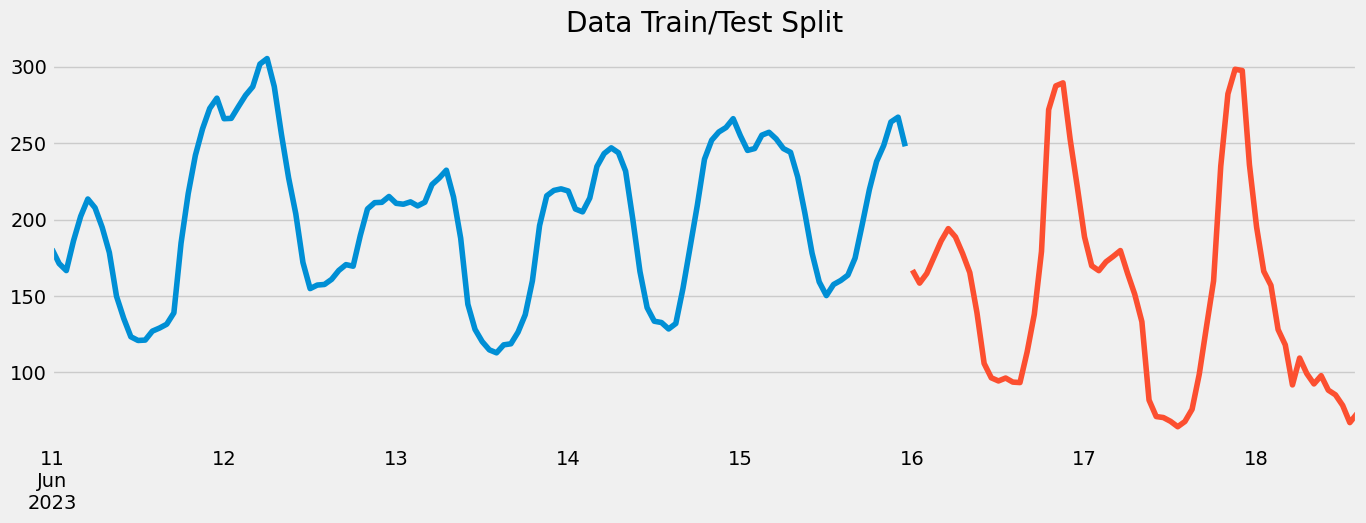

In [182]:
fig, ax = plt.subplots(figsize=(15, 5))
train['Carbon_Intensity_CEI'].plot(
    ax=ax, label='Training Set', title='Data Train/Test Split')
test['Carbon_Intensity_CEI'].plot(ax=ax, label='Test Set')
plt.show()

In [183]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    return df


historical_data = create_features(historical_data)

In [184]:
historical_data.columns

Index(['Biomass_CEI', 'Lignite_CEI', 'Gas_CEI', 'Coal_CEI', 'Oil_CEI',
       'Geothermal_CEI', 'Hydro_storage_CEI', 'Hydro_CEI', 'Hydro_res_CEI',
       'Nuclear_CEI', 'Other_CEI', 'Other_renew_CEI', 'Solar_CEI', 'Waste_CEI',
       'Wind_off_CEI', 'Wind_on_CEI', 'Total_CEI', 'Carbon_Intensity_CEI',
       'time_epoch', 'temp_c', 'wind_kph', 'wind_degree', 'wind_dir',
       'pressure_mb', 'precip_mm', 'humidity', 'cloud', 'feelslike_c',
       'windchill_c', 'vis_km', 'hour', 'dayofweek'],
      dtype='object')

## Train the model


In [222]:
historical_data, weather_forecast = fetch_forecast_data(
    country_code, country, city, tz)

In [223]:
historical_data = create_features(historical_data)
weather_forecast = create_features(weather_forecast)

In [224]:
historical_data
weather_forecast.columns

Index(['temp_c', 'wind_kph', 'wind_degree', 'pressure_mb', 'precip_mm',
       'humidity', 'cloud', 'feelslike_c', 'windchill_c', 'vis_km', 'hour',
       'dayofweek'],
      dtype='object')

In [225]:


FEATURES = ['temp_c', 'wind_kph', 'wind_degree', 'pressure_mb', 'precip_mm',
            'humidity', 'cloud', 'feelslike_c', 'windchill_c', 'vis_km', 'hour',
            'dayofweek']
TARGET = 'Carbon_Intensity_CEI'

X_train = historical_data[FEATURES]
y_train = historical_data[TARGET]


X_test = weather_forecast[FEATURES]

In [226]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=5000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=5,
                       learning_rate=0.02)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
        verbose=100)

[17:02:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:188.19655
[100]	validation_0-rmse:30.82147
[200]	validation_0-rmse:7.92842
[300]	validation_0-rmse:3.98678
[400]	validation_0-rmse:2.65274
[500]	validation_0-rmse:1.87803
[600]	validation_0-rmse:1.40995
[700]	validation_0-rmse:1.04564
[800]	validation_0-rmse:0.82137
[900]	validation_0-rmse:0.63844
[1000]	validation_0-rmse:0.50196
[1100]	validation_0-rmse:0.37627
[1200]	validation_0-rmse:0.29881
[1300]	validation_0-rmse:0.24272
[1400]	validation_0-rmse:0.19667
[1500]	validation_0-rmse:0.15462
[1600]	validation_0-rmse:0.12661
[1700]	validation_0-rmse:0.10156
[1800]	validation_0-rmse:0.08051
[1900]	validation_0-rmse:0.06408
[2000]	validation_0-rmse:0.05328
[2100]	validation_0-rmse:0.04497
[2200]	validation_0-rmse:0.03595
[2300]	validation_0-rmse:0.02802
[24

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

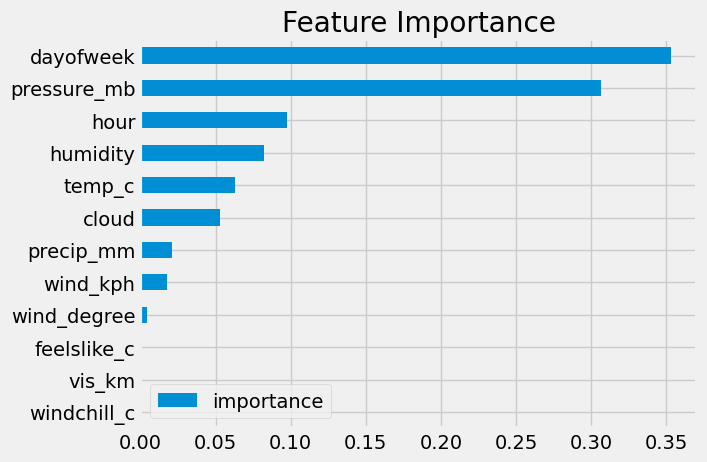

In [228]:
weather_forecast["Cei_prediction"] = reg.predict(X_test)

In [232]:
merge = pd.merge(
    historical_data, weather_forecast['Cei_prediction'], how='outer', left_index=True, right_index=True)

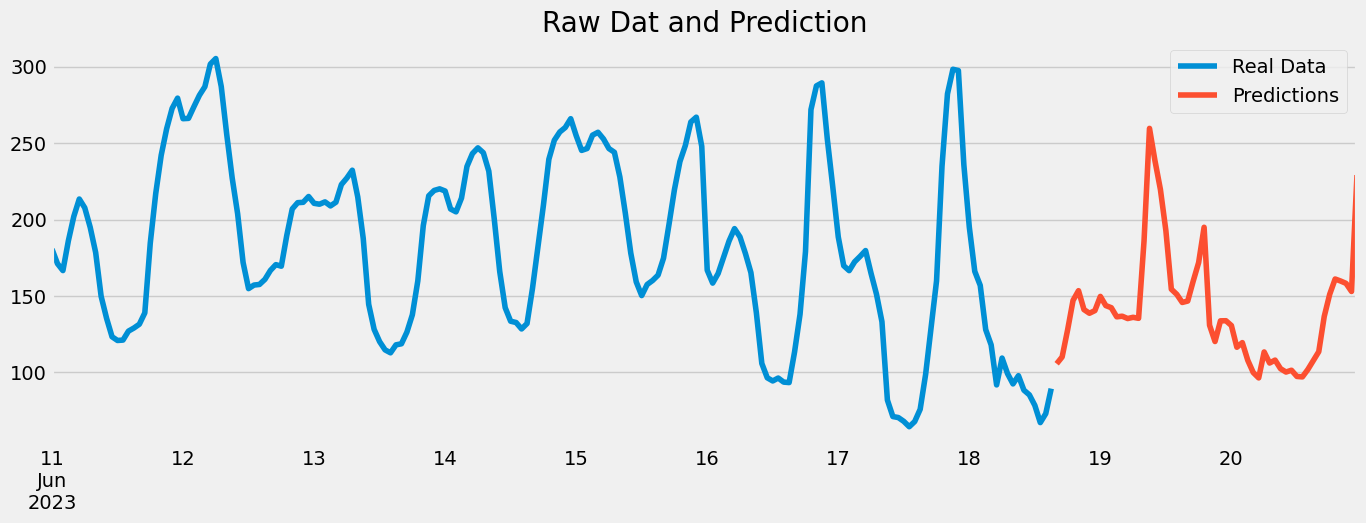

In [235]:
ax = historical_data[["Carbon_Intensity_CEI"]].plot(figsize=(15, 5))
merge["Cei_prediction"].plot(ax=ax, style="-")
plt.legend(["Real Data", "Predictions"])
ax.set_title("Raw Dat and Prediction")
plt.show()

In [153]:
score = np.sqrt(mean_squared_error(
    test['Carbon_Intensity_CEI'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 44.03


In [156]:
def add_lags(df):
    target_map = df["Carbon_Intensity_CEI"].to_dict()
    df["lag1"] = (df.index - pd.Timedelta("1 hour")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("12 hours")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1 day")).map(target_map)
    return df

In [157]:
historical_data = add_lags(historical_data)

In [158]:
historical_data

,Biomass_CEI,Lignite_CEI,Gas_CEI,Coal_CEI,Oil_CEI,Geothermal_CEI,Hydro_storage_CEI,Hydro_CEI,Hydro_res_CEI,Nuclear_CEI,...,humidity,cloud,feelslike_c,windchill_c,vis_km,hour,dayofweek,lag1,lag2,lag3
2023-06-11 00:00:00+02:00,12.42,0.0,517.060,0.0,0.0,0.0,0.0,0.0,0.0,11.900,...,66,12,19.5,19.5,10.0,0,6,NaN,NaN,NaN
2023-06-11 01:00:00+02:00,13.11,0.0,502.640,0.0,0.0,0.0,0.0,0.0,0.0,11.905,...,66,17,19.2,19.2,10.0,1,6,180.660253,NaN,NaN
2023-06-11 02:00:00+02:00,12.42,0.0,489.765,0.0,0.0,0.0,0.0,0.0,0.0,11.910,...,67,22,18.7,18.7,10.0,2,6,171.177732,NaN,NaN
2023-06-11 03:00:00+02:00,12.88,0.0,542.295,0.0,0.0,0.0,0.0,0.0,0.0,11.920,...,70,14,18.0,18.0,10.0,3,6,166.588079,NaN,NaN
2023-06-11 04:00:00+02:00,12.42,0.0,580.920,0.0,0.0,0.0,0.0,0.0,0.0,11.935,...,74,6,17.1,17.1,10.0,4,6,186.079461,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-18 10:00:00+02:00,1.38,0.0,315.180,0.0,0.0,0.0,0.0,0.0,0.0,16.925,...,50,61,25.3,24.1,10.0,10,6,97.795773,297.541392,71.035362
2023-06-18 11:00:00+02:00,1.38,0.0,316.725,0.0,0.0,0.0,0.0,0.0,0.0,16.915,...,57,89,25.1,23.5,10.0,11,6,88.311083,235.885604,70.372598
2023-06-18 12:00:00+02:00,1.38,0.0,302.305,0.0,0.0,0.0,0.0,0.0,0.0,16.920,...,66,70,24.6,22.1,10.0,12,6,85.241499,195.036962,67.880783
2023-06-18 13:00:00+02:00,1.61,0.0,256.470,0.0,0.0,0.0,0.0,0.0,0.0,16.905,...,77,80,20.7,20.7,10.0,13,6,78.346738,166.073582,64.366137


In [159]:
historical_data.columns

Index(['Biomass_CEI', 'Lignite_CEI', 'Gas_CEI', 'Coal_CEI', 'Oil_CEI',
       'Geothermal_CEI', 'Hydro_storage_CEI', 'Hydro_CEI', 'Hydro_res_CEI',
       'Nuclear_CEI', 'Other_CEI', 'Other_renew_CEI', 'Solar_CEI', 'Waste_CEI',
       'Wind_off_CEI', 'Wind_on_CEI', 'Total_CEI', 'Carbon_Intensity_CEI',
       'time_epoch', 'temp_c', 'wind_kph', 'wind_degree', 'wind_dir',
       'pressure_mb', 'precip_mm', 'humidity', 'cloud', 'feelslike_c',
       'windchill_c', 'vis_km', 'hour', 'dayofweek', 'lag1', 'lag2', 'lag3'],
      dtype='object')

In [163]:
# Retrain on all data
historical_data = create_features(historical_data)

FEATURES = ['Biomass_CEI', 'Lignite_CEI', 'Gas_CEI', 'Coal_CEI', 'Oil_CEI',
            'Geothermal_CEI', 'Hydro_storage_CEI', 'Hydro_CEI', 'Hydro_res_CEI',
            'Nuclear_CEI', 'Other_CEI', 'Other_renew_CEI', 'Solar_CEI', 'Waste_CEI',
            'Wind_off_CEI', 'Wind_on_CEI', 'temp_c', 'wind_kph', 'wind_degree',
            'pressure_mb', 'precip_mm', 'humidity', 'cloud', 'feelslike_c',
            'windchill_c', 'vis_km', 'hour', 'dayofweek', 'lag1', 'lag2', 'lag3']
TARGET = 'Carbon_Intensity_CEI'

X_all = historical_data[FEATURES]
y_all = historical_data[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)
trained_model = MultiOutputRegressor(reg).fit(x_train, y_train)

[16:26:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:190.36214
[100]	validation_0-rmse:73.43028
[200]	validation_0-rmse:29.79049
[300]	validation_0-rmse:13.33489
[400]	validation_0-rmse:7.36876
[499]	validation_0-rmse:5.13439


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [164]:
historical_data.index.max()

Timestamp('2023-06-18 14:00:00+0200', tz='Europe/Brussels')

In [165]:
# Create future dataframe
future = pd.date_range(historical_data.index.max(),
                       weather_forecast.index.max(), freq='1h')
forecast = pd.DataFrame(index=future)
forecast['isFuture'] = True
historical_data['isFuture'] = False
historical_and_forecast = pd.concat([historical_data, forecast])
historical_and_forecast = create_features(historical_and_forecast)
historical_and_forecast = add_lags(historical_and_forecast)

In [166]:
future_w_features = historical_and_forecast.query("isFuture").copy()

In [167]:
future_w_features["pred"] = reg.predict(future_w_features[FEATURES])

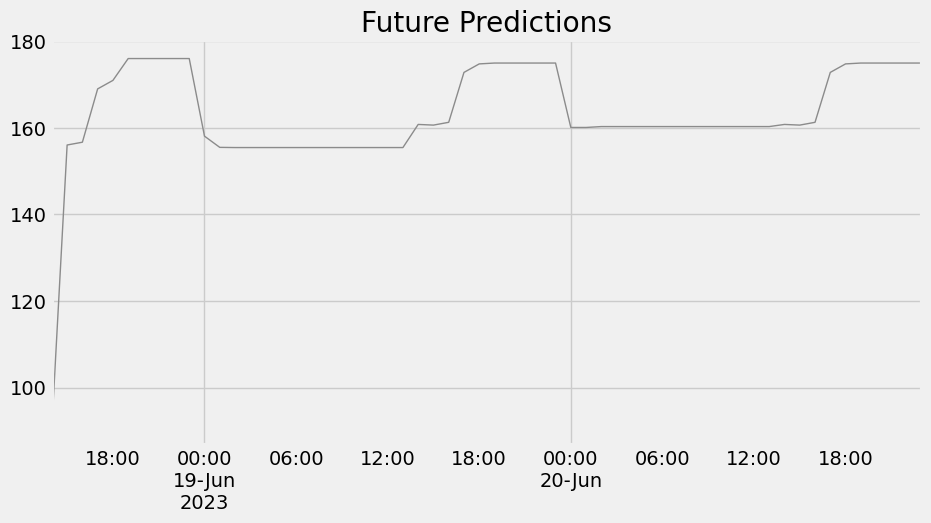

In [168]:
future_w_features["pred"].plot(
    figsize=(10, 5), color=color_pal[4], ms=1, lw=1, title="Future Predictions"
)
plt.show()

In [169]:
reg.save_model("model.json")

<Axes: title={'center': 'Future Predictions'}>

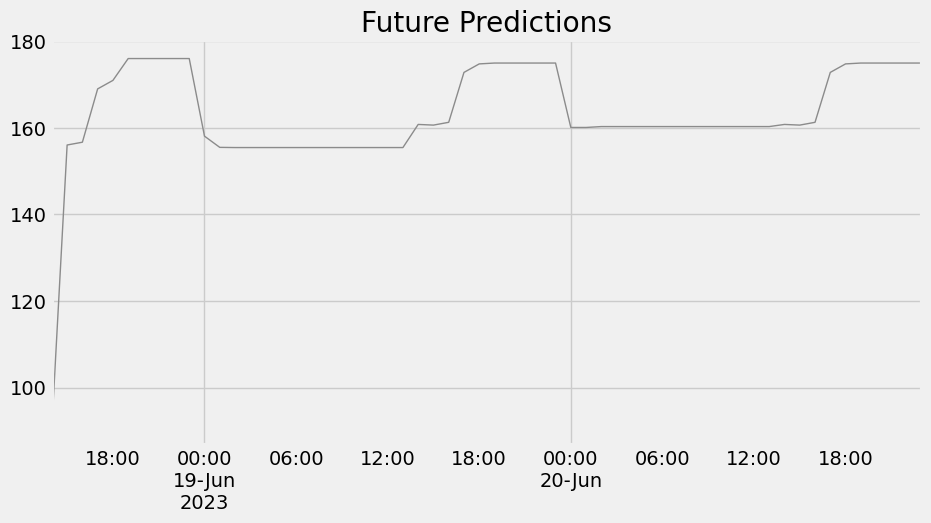

In [170]:
reg_new = xgb.XGBRegressor()
reg_new.load_model("model.json")
future_w_features["pred"] = reg_new.predict(future_w_features[FEATURES])
future_w_features["pred"].plot(
    figsize=(10, 5), color=color_pal[4], ms=1, lw=1, title="Future Predictions"
)

In [174]:
historical_data, weather_forecast = fetch_forecast_data(
    country_code, country, city, tz)

In [175]:
historical_data = create_features(historical_data)
historical_data = add_lags(historical_data)

FEATURES = ['Biomass_CEI', 'Lignite_CEI', 'Gas_CEI', 'Coal_CEI', 'Oil_CEI',
            'Geothermal_CEI', 'Hydro_storage_CEI', 'Hydro_CEI', 'Hydro_res_CEI',
            'Nuclear_CEI', 'Other_CEI', 'Other_renew_CEI', 'Solar_CEI', 'Waste_CEI',
            'Wind_off_CEI', 'Wind_on_CEI', 'temp_c', 'wind_kph', 'wind_degree',
            'pressure_mb', 'precip_mm', 'humidity', 'cloud', 'feelslike_c',
            'windchill_c', 'vis_km', 'hour', 'dayofweek', 'lag1', 'lag2', 'lag3']
TARGET = 'Carbon_Intensity_CEI'

X_all = historical_data[FEATURES]
y_all = historical_data[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[16:36:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:190.36214
[100]	validation_0-rmse:73.43028
[200]	validation_0-rmse:29.79049
[300]	validation_0-rmse:13.33489
[400]	validation_0-rmse:7.36876
[499]	validation_0-rmse:5.13439


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

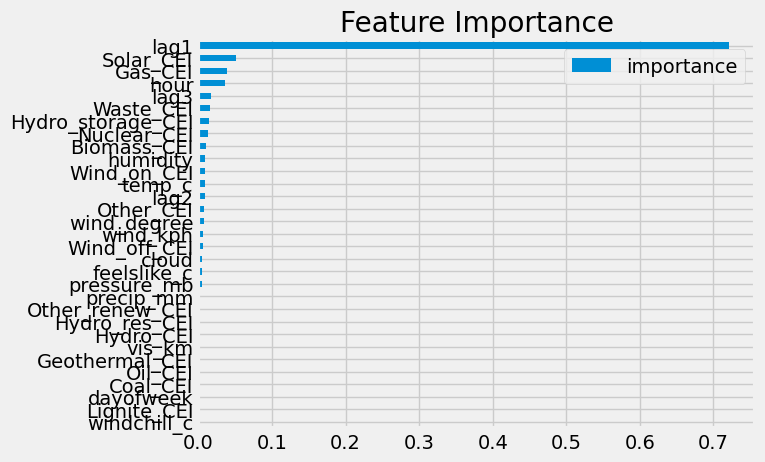

In [176]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
test['prediction'] = reg.predict(X_test)
df = historical_data.merge(
    test[['prediction']], how='left', left_index=True, right_index=True)
ax = historical_data[['Carbon_Intensity_CEI']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Real Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()